<div align=center>
    <font size=5>Feature Selection</font>
</div>

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import xgboost as xgb
import itertools
from sklearn import svm
from sklearn import tree
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.linear_model import LassoCV, LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    roc_curve,
    precision_score,
    recall_score
)

### Tools Function

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.yticks(np.arange(-0.5,1.5,0.25), ["","",classes[0],"","","",classes[1],"",""], size = 14)
    plt.xticks(tick_marks, classes, rotation=45, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [3]:
def evaluate_model(test_labels,predictions, probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    baseline = {}
    
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves')

### 数据

#### 基本情况

In [4]:
df = pd.read_excel('./src_data.xlsx')
pd.options.display.max_columns = None
df.head()

,AGE,SEX,H_HT,H_DM,H_HL,H_CHD,H_AF,H_STROKE_TIA,H_MRS345,CURRENT_SMOKE,SYMPTOM,LVOD,LVOP,A_MAP,A_NIH,A_GCS,A_WBC,A_GLU,A_SCR,A_PCASPECTS,A_PMI,A_BERN,A_THALAMUS2,A_CEREBELLUM,A_IVT,MIDDLE_BAO,ASITN_SIR,PCOA,BATMAN,FR
0,54,1,1,0,0,0,0,0,0,1,2,9.0,13.0,90.33,16,11,22.07,9.20,53.87,3,4,9,0,1,0,1,2,1,4,1
1,29,1,0,0,0,0,0,0,0,1,1,17.0,18.0,110.00,31,5,21.00,7.03,76.90,6,4,8,0,0,0,0,2,0,5,1
2,70,1,1,0,0,0,0,0,0,0,2,6.0,7.0,106.67,35,3,20.06,8.39,94.80,5,4,7,0,0,0,0,1,1,4,0
3,60,1,1,0,0,0,0,0,0,0,2,2.5,4.5,103.33,35,3,19.43,8.12,87.10,8,0,3,0,1,0,0,1,1,2,1
4,47,1,1,1,1,0,0,0,0,0,2,13.0,18.0,114.00,23,11,19.00,15.41,56.40,4,5,9,0,1,0,0,2,1,3,1


#### 类别型属性编码及数据集划分

In [5]:
numerical_features = [
    "AGE",
    "LVOD",
    "LVOP",
    "A_MAP",
    "A_NIH",
    "A_GCS",
    "A_WBC",
    "A_GLU",
    "A_SCR",
    "A_PCASPECTS",
    "A_PMI",
    "A_BERN",
    "PCOA",
    "BATMAN"
]

In [6]:
category_features = list(df.columns.drop(numerical_features+['FR']))

In [7]:
category_features

['SEX',
 'H_HT',
 'H_DM',
 'H_HL',
 'H_CHD',
 'H_AF',
 'H_STROKE_TIA',
 'H_MRS345',
 'CURRENT_SMOKE',
 'SYMPTOM',
 'A_THALAMUS2',
 'A_CEREBELLUM',
 'A_IVT',
 'MIDDLE_BAO',
 'ASITN_SIR']

In [8]:
X = df.drop(['FR'],axis=1)
Y = df['FR']
X = pd.get_dummies(X,columns=category_features)

In [9]:
X = pd.DataFrame(StandardScaler().fit_transform(X),columns = X.columns)

In [10]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(
    X, Y, test_size=0.30, random_state=101
)

In [11]:
X_Train.shape,X_Test.shape

((80, 47), (35, 47))

### Basic Classifier

In [12]:
def info(Xtrain,Xtest,ytrain,ytest):
    start = time.process_time()
    model = xgb.XGBClassifier(learning_rate=0.01,n_estimators=96,max_depth=3).fit(Xtrain,ytrain)
    print("Time Consuming:",time.process_time() - start)
    preds = model.predict(Xtest)
    cm = confusion_matrix(ytest,preds)
#     print(cm)
    plot_confusion_matrix(cm,classes=['FR=0','FR=1'])
    print(classification_report(ytest,preds))
    probs = model.predict_proba(Xtest)[:,1]
    print("ROC_AUC:",roc_auc_score(ytest,probs))
    evaluate_model(Y_Test,preds,probs)
    return model

Time Consuming: 0.03125
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.80      0.63      0.71        19
           1       0.65      0.81      0.72        16

    accuracy                           0.71        35
   macro avg       0.73      0.72      0.71        35
weighted avg       0.73      0.71      0.71        35

ROC_AUC: 0.7171052631578947


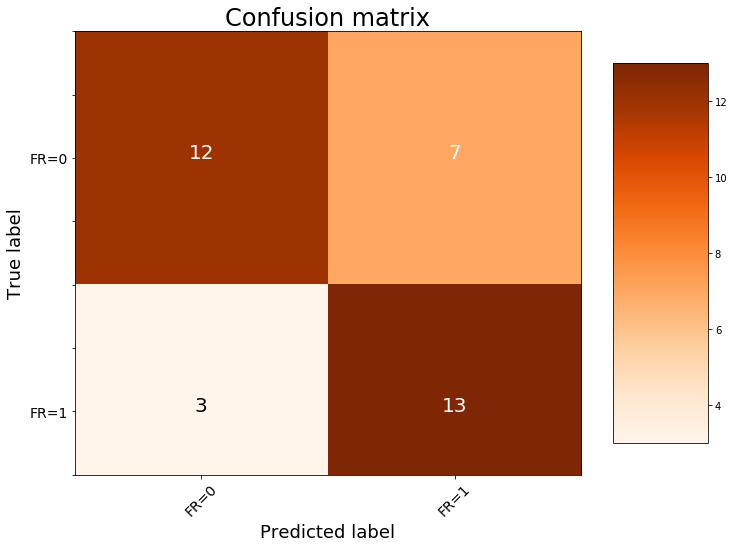

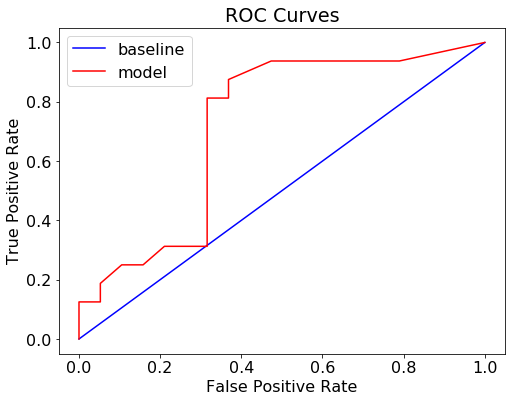

In [13]:
basic_model = info(X_Train,X_Test,Y_Train,Y_Test)

### 特征选择（基于XGBoost）

In [14]:
feats_importance = pd.Series(basic_model.feature_importances_,index=X.columns)

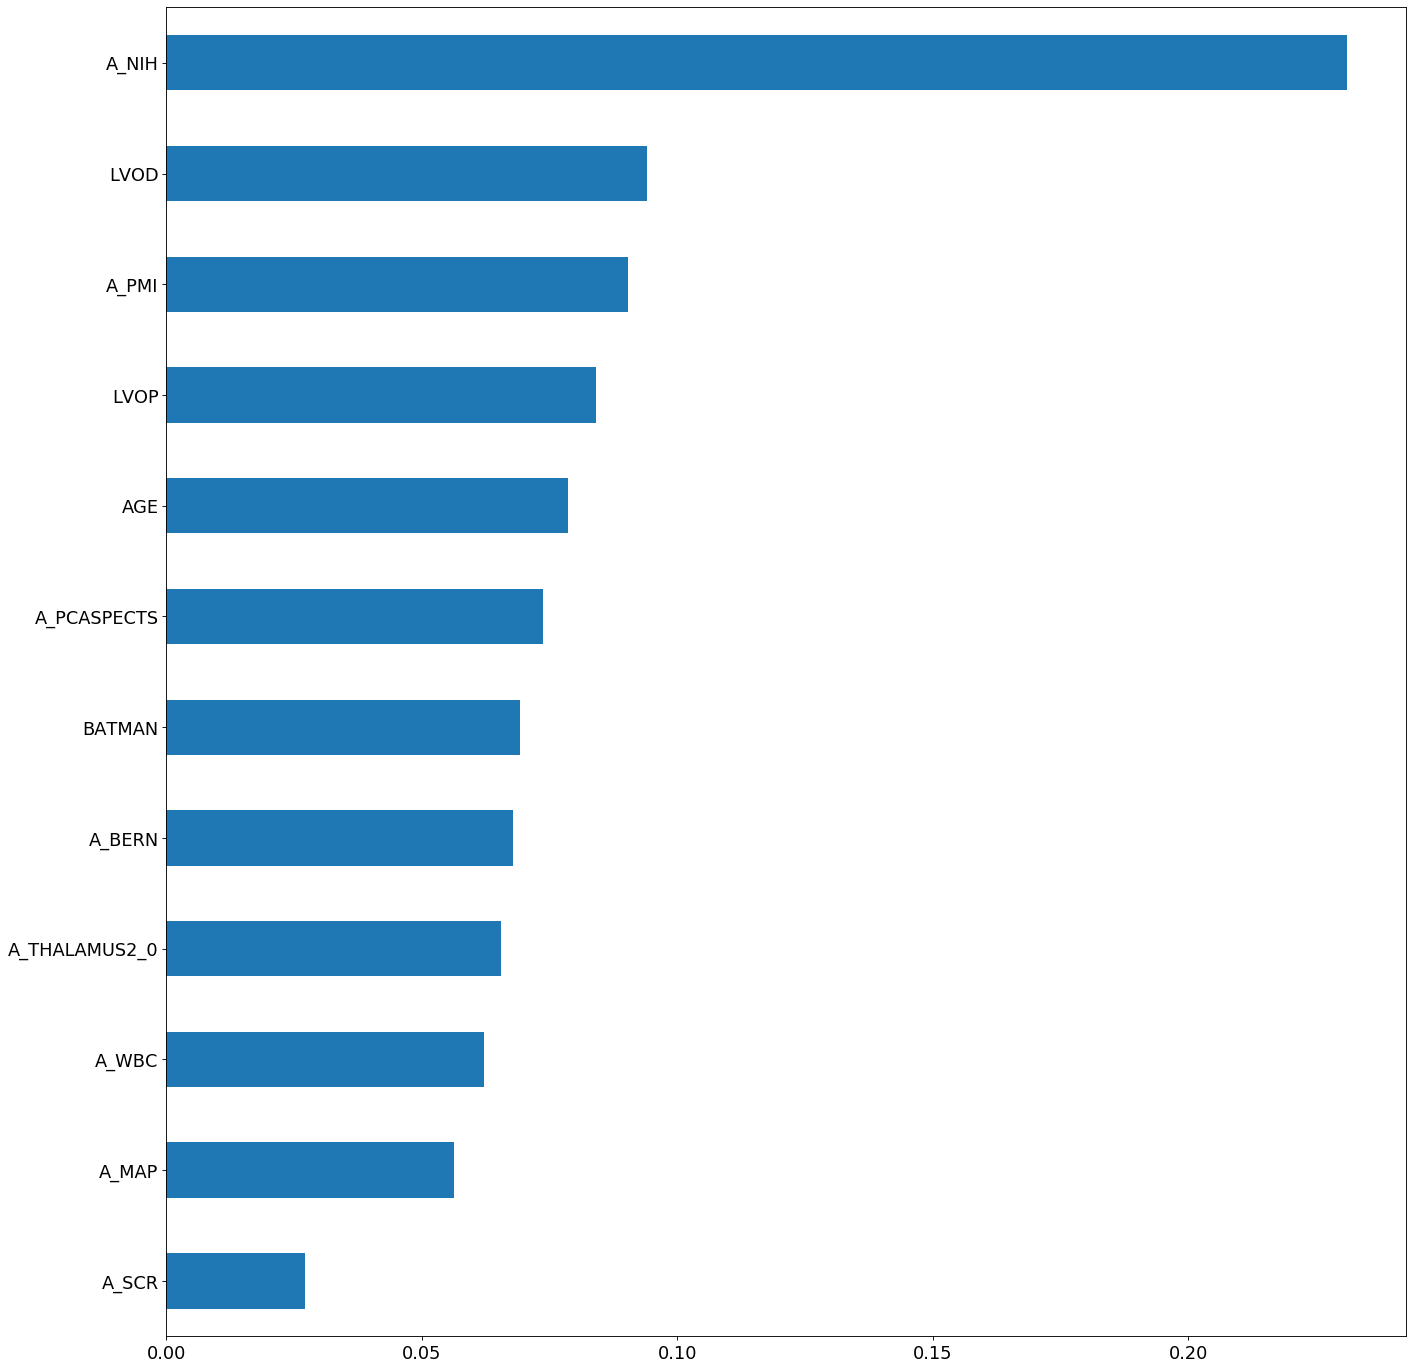

In [16]:
figure(num=None,figsize=(20, 22), dpi=80, facecolor='w', edgecolor='k')
feats_importance[feats_importance>0].sort_values().plot(kind='barh')

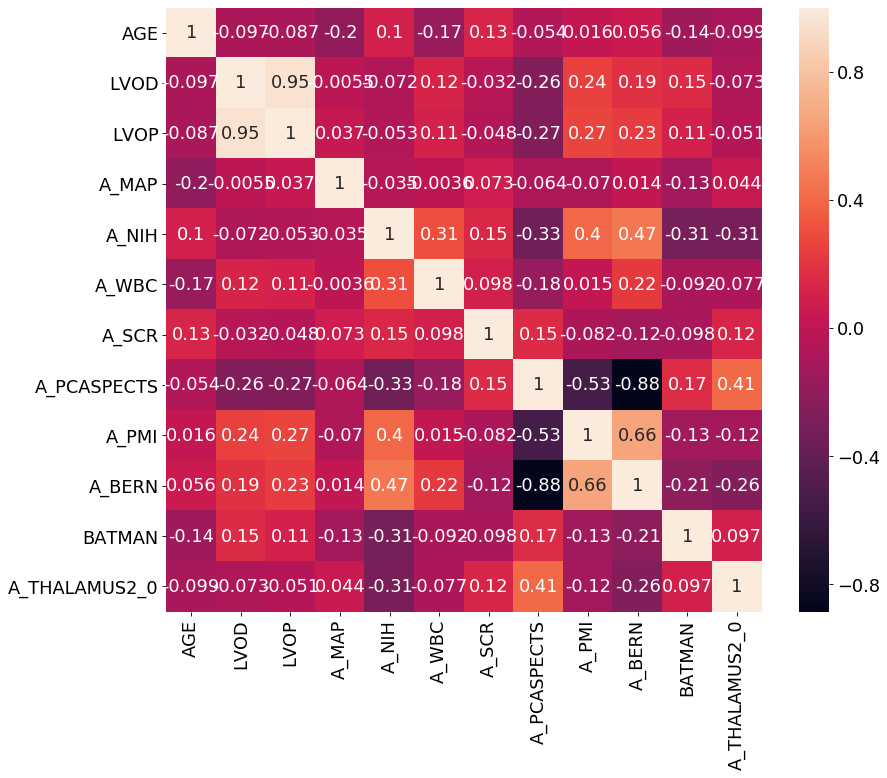

In [19]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

corr = X[feats_importance[feats_importance > 0].index].corr()

sns.heatmap(corr, annot=True, fmt=".2g")

"LVOD"与"LVOP"有较强的正相关性，值为$0.95$，"A_PCASPECTS"与"A_BERN"有较强的负相关性，值为$-0.88$.

In [21]:
X_Reduced = X[feats_importance[feats_importance>0].index.drop(["LVOP",'A_PCASPECTS'])]
X_Reduced = pd.DataFrame(StandardScaler().fit_transform(X_Reduced))
X_Train2, X_Test2, Y_Train2, Y_Test2 = train_test_split(X_Reduced, Y, test_size = 0.30, 
                                                        random_state = 101)

Time Consuming: 0.015625
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.75      0.63      0.69        19
           1       0.63      0.75      0.69        16

    accuracy                           0.69        35
   macro avg       0.69      0.69      0.69        35
weighted avg       0.70      0.69      0.69        35

ROC_AUC: 0.761513157894737


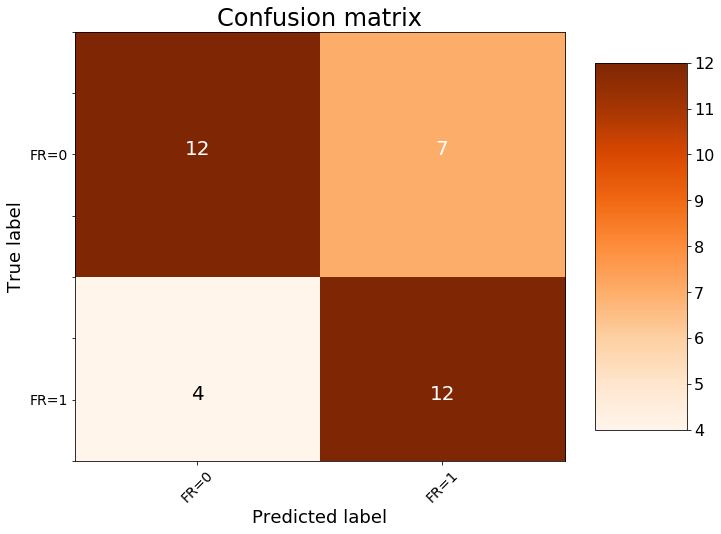

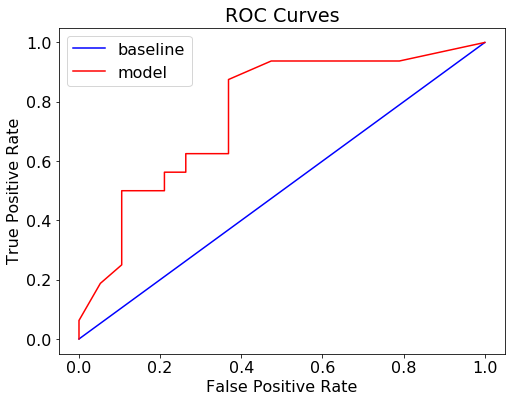

In [24]:
model_Reduced = info(X_Train2,X_Test2,Y_Train2,Y_Test2)

使用**递归特征选择**$(Recursive Feature Elimination,RFE)$进行特征选择后保留的特征与上面保留特征基本相同，只是少了最后两个特征$A\_MAP$和$A\_SCR$.

### 仅保留$A\_NIH$属性

In [26]:
X_Reduced2 = X[['A_NIH']]
X_Reduced2 = pd.DataFrame(StandardScaler().fit_transform(X_Reduced2))
X_Train3, X_Test3, Y_Train3, Y_Test3 = train_test_split(X_Reduced2, Y, test_size = 0.30, 
                                                        random_state = 101)

Time Consuming: 0.0
Confusion matrix, without normalization
              precision    recall  f1-score   support

           0       0.80      0.63      0.71        19
           1       0.65      0.81      0.72        16

    accuracy                           0.71        35
   macro avg       0.73      0.72      0.71        35
weighted avg       0.73      0.71      0.71        35

ROC_AUC: 0.7648026315789473


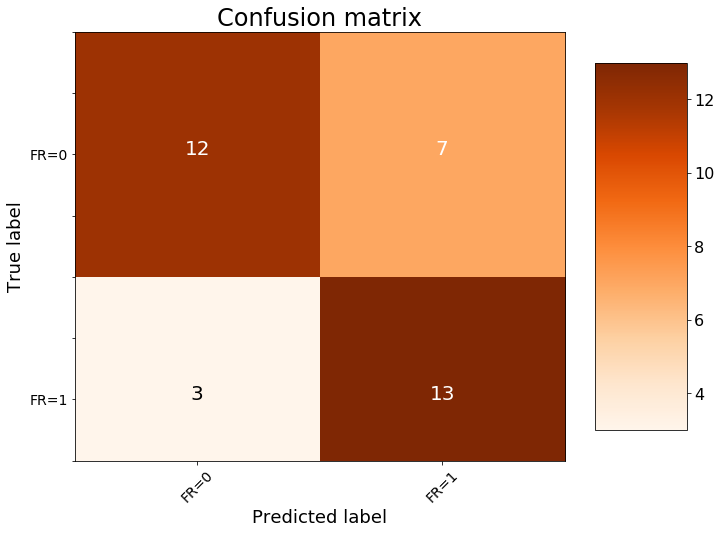

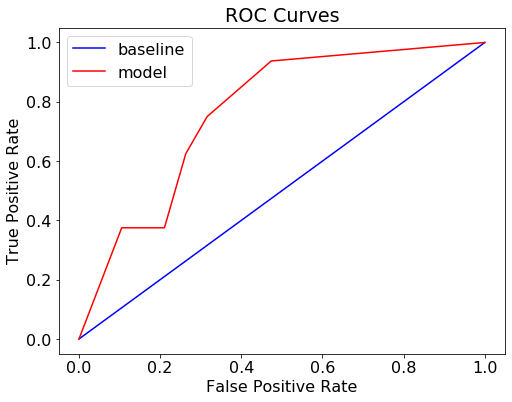

In [28]:
model_Reduced2 = info(X_Train3,X_Test3,Y_Train3,Y_Test3)

仅保留A_NIH一个属性，模型准确率也没有下降，说明模型准确率主要依靠A_NIH属性，而其他属性主要影响了模型ROC指标。

### LASSO Regression

#### 手动实现

In [30]:
logistic = LogisticRegression(penalty="l1",C=1.0, random_state=7).fit(X_Train,Y_Train)
# C : float, optional (default=1.0)
#     Inverse of regularization strength; must be a positive float.
#     Like in support vector machines, smaller values specify stronger
#     regularization.
model = SelectFromModel(logistic,prefit=True)
logistic_coef = pd.Series(logistic.coef_[0], index = X_Train.columns)

c:\users\you\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 1.0, 'Most Important Features Identified using logistic_L1 (!0,C=1.0)')

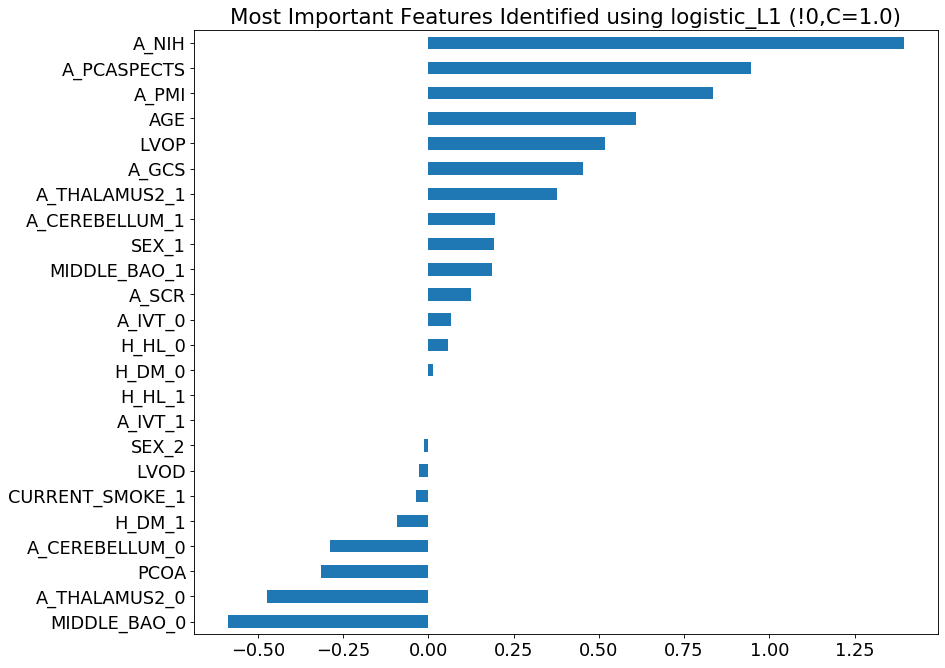

In [32]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

top_logistic_coef = logistic_coef.sort_values()
top_logistic_coef [top_logistic_coef  != 0].plot(kind = "barh")
plt.title("Most Important Features Identified using logistic_L1 (!0,C=1.0)")

##### 降低参数C的值

In [40]:
logistic2 = LogisticRegression(penalty="l1",C=0.2, random_state=7).fit(X_Train,Y_Train)
model2 = SelectFromModel(logistic2,prefit=True)
logistic_coef2 = pd.Series(logistic2.coef_[0], index = X_Train.columns)

c:\users\you\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Text(0.5, 1.0, 'Most Important Features Identified using logistic_L1 (!0,C=0.2)')

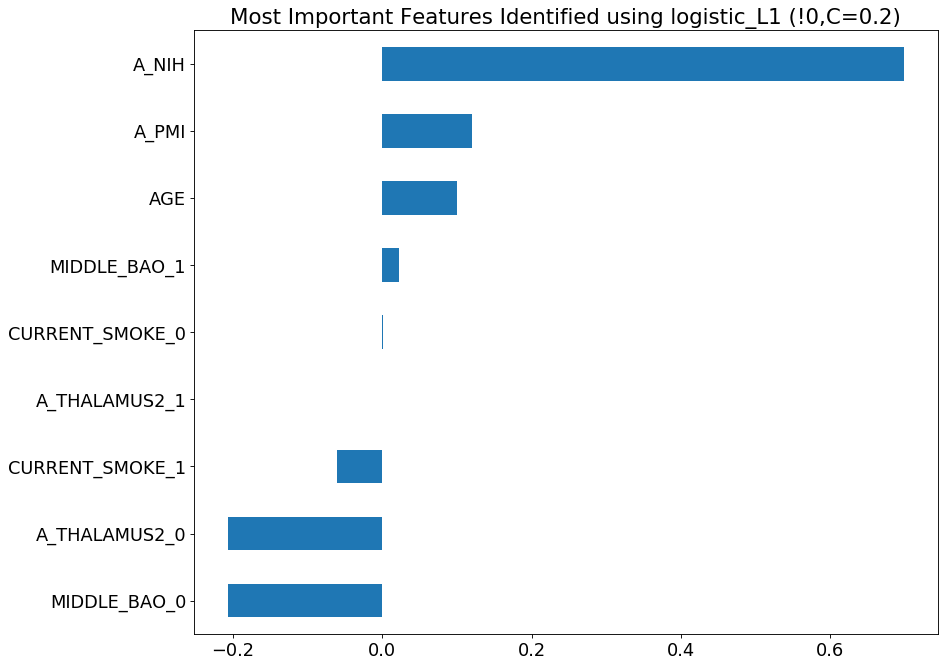

In [41]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')

top_logistic_coef2 = logistic_coef2.sort_values()
top_logistic_coef2 [top_logistic_coef2  != 0].plot(kind = "barh")
plt.title("Most Important Features Identified using logistic_L1 (!0,C=0.2)")

#### 使用sklearn封装好的LassoCV

In [42]:
regr = LassoCV(cv=4,random_state=101)
regr.fit(X_Train,Y_Train)
print("LassoCV Best Alpha Scored: ", regr.alpha_)
print("LassoCV Model Accuracy: ", regr.score(X_Test, Y_Test))
model_coef = pd.Series(regr.coef_, index = X.columns)
print("Variables Eliminated: ", str(sum(model_coef == 0)))
print("Variables Kept: ", str(sum(model_coef != 0))) 

LassoCV Best Alpha Scored:  0.028864951441798004
LassoCV Model Accuracy:  0.3257782772222587
Variables Eliminated:  30
Variables Kept:  17


Text(0.5, 1.0, 'Most Important Features Identified using Lasso (!0)')

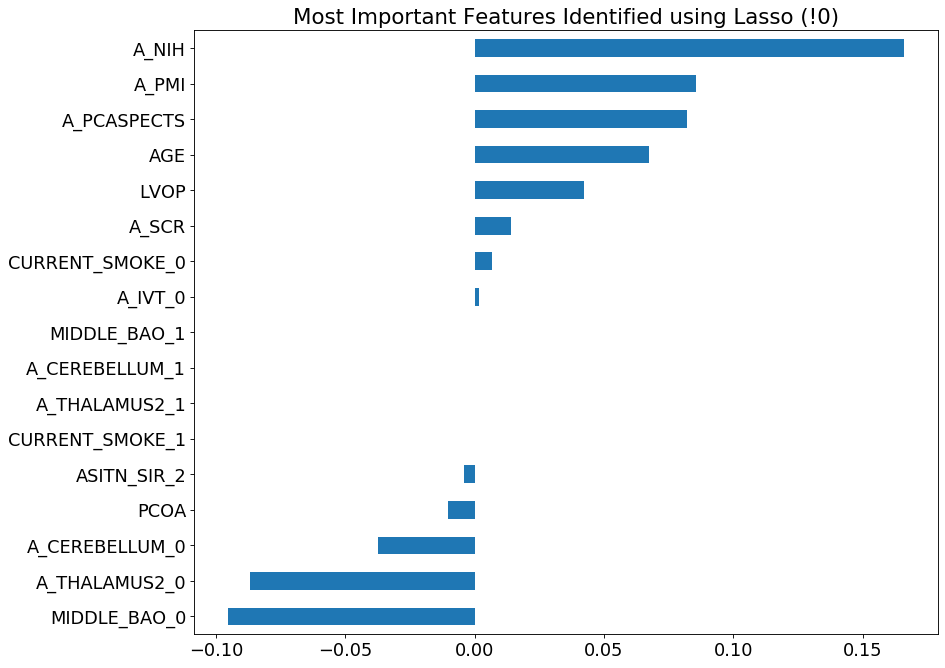

In [43]:
figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
top_coef = model_coef.sort_values()
top_coef[top_coef != 0].plot(kind = "barh")
plt.title("Most Important Features Identified using Lasso (!0)")